# I. Importation des packages

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import ImageChops,Image
import glob
import cv2
import os
import time

# I.  Extraction de donnees

In [124]:
# define a dictionnary of each arabic word with its translated one in english
arabic_to_english = {
    'ا': 'alif',
    'ء': 'h_amza',
    'ب': 'ba',
    'ت': 'ta',
    'ث': 'tha',
    'ة': 'tae_marbota',
    'ج': 'jim',
    'ح': 'hae',
    'خ': 'kha',
    'د': 'dal',
    'ذ': 'dhal',
    'ر': 'ra',
    'ز': 'za',
    'س': 'sin',
    'ش': 'shin',
    'ص': 'sad',
    'ض': 'dad',
    'ط': 'tta',
    'ظ': 'ddad',
    'ع': 'ayn',
    'غ': 'ghayn',
    'ف': 'fa',
    'ق': 'qaf',
    'ك': 'kaf',
    'ل': 'lam',
    'لا':'lam_alif',
    'م': 'mim',
    'ن': 'nun',
    'ه': 'haae',
    'و': 'waw',
    'ي': 'yae',
    'ى':'alif_maksoura'
}

- preparation des images

In [125]:
def trim(image):
    image=Image.fromarray(image)
    bg = Image.new(image.mode, image.size, image.getpixel((0,0))) # black background
    diff = ImageChops.difference(image, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return np.array(image.crop(bbox))
# cv2.INTER_AREA: examiner les pixels voisins et utiliser ces voisins pour augmenter ou diminuer optiquement la taille de l’image sans introduire de distorsions
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    resized = cv2.resize(image, dim, interpolation = inter)
    return resized
def cleaned_image(image):
    bg=np.zeros((100,100))
    image=trim(image)
    image=image_resize(image,height=100)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    hh, ww = bg.shape
    h, w = image_binary.shape
    yoff = round((hh-h)/2)
    xoff = round((ww-w)/2)
    if xoff<=0:
        image=image_resize(image,height=100,width=100)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh, image_binary = cv2.threshold(image_gray, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        h, w = image_binary.shape
        yoff = round((hh-h)/2)
        xoff = round((ww-w)/2)
    result = bg.copy()
    result[yoff:yoff+h, xoff:xoff+w] = image_binary
    return result

##### Importation des images

In [128]:
path = "../Datasets/letters/"
dir_list = os.listdir(path)
df=list([])
labe=[]
for i in dir_list:
    dir_letters = os.listdir("../Datasets/letters/" + i)
    for k in dir_letters:
        image_files= os.listdir("../Datasets/letters/" + i+"/"+k)
        for j in image_files:
            label=i+"_"+k
            labe.append(label)
            im=cv2.imread("../Datasets/letters/" + i+"/"+k+"/"+j)
            cleaned=cleaned_image(im)
            img=cleaned.reshape(100*100) #On a redimensionner chaque indivisu (image) sous format d'un vecteur de 28*28=784 variables
            df.append(img)

##### Stocker les images dans le dataframe

In [129]:
df=pd.DataFrame(df)
df["target"]=labe

In [130]:
df.shape

(4177, 10001)

In [43]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,alif_end
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,alif_end
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,alif_end
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,alif_end
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,alif_end


##### Distribution  de donnees

<AxesSubplot:xlabel='target'>

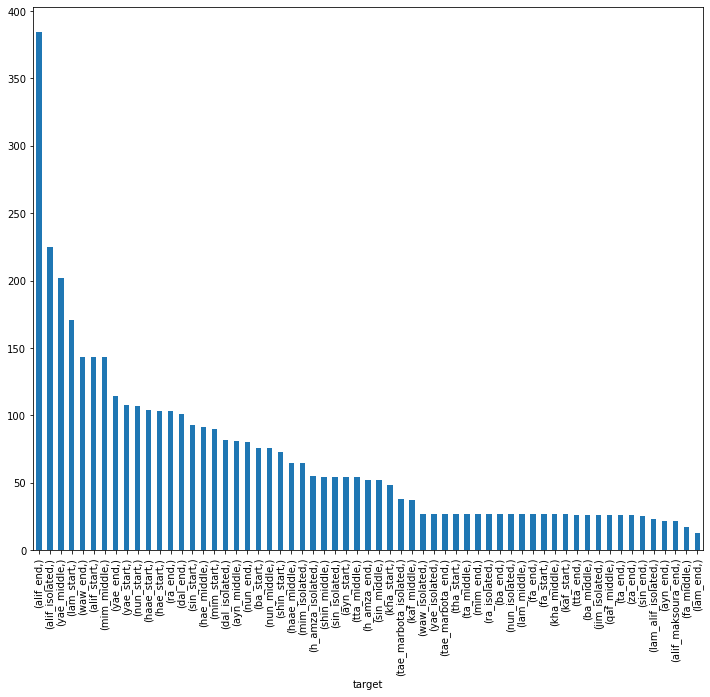

In [170]:
#etudiant la distribution des lettres
pd.DataFrame(df["target"]).value_counts().plot.bar(figsize=(12,10))

- On remarque que les classes du dataset sont distribuées d'une manière déséquilibre

## II.  Transformation de donnees

##### Redimensionnemnt des individus

In [71]:
from sklearn.model_selection import train_test_split
y = filtered_df1[['target']]
X = filtered_df1.drop(['target', ], axis = 1)
X=X/255 # les valeurs du matrice est entre [0,1]

In [144]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.1)
#n_splits : détermine le nombre de fois que le jeu de données sera divisé en deux sous-ensembles, un ensemble d'entraînement et un ensemble de test.
#test_size : la taille de la partie des test dans notre jeu de données.
sss.get_n_splits(X, y)

4

## III.  Modélisation

In [145]:
from sklearn.metrics import accuracy_score 
scores = []
count=0
 
rf = RandomForestClassifier(n_estimators=200, max_depth=100,bootstrap=True)
#max_depth : La max_depth d’un arbre dans Random Forest est définie comme le chemin le plus long entre le nœud racine et le nœud feuille.
#n_estimators : Nombre d’arbres dans la forêt
#bootstrap : Méthode d’échantillonnage des points de données (avec ou sans remplacement).
for train_index, test_index in sss.split(X, y): # explorer les sous-ensembles
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] # la partie d'entrainement
    y_train, y_test = y.iloc[train_index],  y.iloc[test_index] # la partie de test
    rf.fit(X_train, y_train.values.ravel()) # Entrainer le modele
    print("n_splits ",count) # afficher le sous-ensemble
    print("accuracy de train : ",rf.score(X_train,y_train.values.ravel())*100) # afficher l'accuracy d'entrainement
    print("accuracy de test : ",rf.score(X_test,y_test.values.ravel())*100) # afficher l'accuracy de test
    count=count+1

n_splits  0
accuracy de train :  100.0
accuracy de test :  60.0
n_splits  1
accuracy de train :  100.0
accuracy de test :  58.5
n_splits  2
accuracy de train :  100.0
accuracy de test :  62.0
n_splits  3
accuracy de train :  100.0
accuracy de test :  60.0


### visualiser un exemple de resultats

In [162]:
rf.predict(X_test.iloc[1:2])

array(['nun_end'], dtype=object)

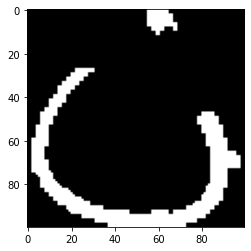

In [164]:
plt.imshow(np.array(X_test.iloc[1:2]).reshape(100,100),cmap="gray")